In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics

from src.reasoner_mod import *
from src.generate import load_dataset
from src.reasoner import *
from src.utils import *
from src.vis import *
import random

In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)

emb_size = 10
hidden_size = 16
epoch_count = 7
test_epoch_count = 12
batch_size = 32

T.manual_seed(seed)
random.seed(seed)
trained_reasoner = ModifiedReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [ModifiedEmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')

train_logger = train_mod(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count, batch_size=batch_size,train_identities=True, lr_reasoner=0.00028, identities_weight=0.2)

created reasoner with 3283 parameters
created 40 encoders with 1270 parameters each
train epoch 0/7 | batch 2001/2000 | loss 1.8555 | val loss 0.7716 | acc 0.2131 | f1 0.3514 | prec 0.2131 | recall 1.0000 | roc auc 0.5142 | pr auc 0.2463 | elapsed 32.25s
train epoch 1/7 | batch 2001/2000 | loss 1.0863 | val loss 0.5396 | acc 0.7256 | f1 0.3929 | prec 0.3717 | recall 0.4167 | roc auc 0.6624 | pr auc 0.4652 | elapsed 91.22s
train epoch 2/7 | batch 2001/2000 | loss 0.7693 | val loss 0.4798 | acc 0.7666 | f1 0.5122 | prec 0.4617 | recall 0.5751 | roc auc 0.7695 | pr auc 0.5873 | elapsed 92.09s
train epoch 3/7 | batch 2001/2000 | loss 0.5672 | val loss 0.4018 | acc 0.8244 | f1 0.6127 | prec 0.5780 | recall 0.6519 | roc auc 0.8401 | pr auc 0.7000 | elapsed 92.07s
train epoch 4/7 | batch 2001/2000 | loss 0.4314 | val loss 0.3614 | acc 0.8522 | f1 0.6753 | prec 0.6351 | recall 0.7208 | roc auc 0.8771 | pr auc 0.7693 | elapsed 92.17s
train epoch 5/7 | batch 2001/2000 | loss 0.3430 | val loss 0.

In [4]:
train_logger = train_mod(data_tr, data_vl, trained_reasoner, encoders, epoch_count=4, batch_size=batch_size,train_identities=True, identities_weight=0.01, lr_reasoner=0.00005)

train epoch 0/4 | batch 2001/2000 | loss 0.1543 | val loss 0.3052 | acc 0.8895 | f1 0.7470 | prec 0.7295 | recall 0.7654 | roc auc 0.9193 | pr auc 0.8411 | elapsed 64.39s
train epoch 1/4 | batch 2001/2000 | loss 0.1533 | val loss 0.2585 | acc 0.9084 | f1 0.7820 | prec 0.7933 | recall 0.7710 | roc auc 0.9345 | pr auc 0.8753 | elapsed 91.16s
train epoch 2/4 | batch 2001/2000 | loss 0.1253 | val loss 0.2470 | acc 0.9124 | f1 0.7934 | prec 0.7980 | recall 0.7889 | roc auc 0.9402 | pr auc 0.8861 | elapsed 82.94s
train epoch 3/4 | batch 2001/2000 | loss 0.1114 | val loss 0.2407 | acc 0.9144 | f1 0.7995 | prec 0.7981 | recall 0.8009 | roc auc 0.9439 | pr auc 0.8931 | elapsed 76.97s
train epoch 4/4 | batch 2001/2000 | loss 0.1006 | val loss 0.2374 | acc 0.9164 | f1 0.8039 | prec 0.8036 | recall 0.8041 | roc auc 0.9463 | pr auc 0.8977 | elapsed 78.54s


In [5]:
train_logger = train_mod(data_tr, data_vl, trained_reasoner, encoders, epoch_count=3, batch_size=batch_size,train_identities=True, identities_weight=0.002, lr_reasoner=0.00001)

train epoch 0/3 | batch 2001/2000 | loss 0.0822 | val loss 0.2361 | acc 0.9167 | f1 0.8043 | prec 0.8052 | recall 0.8035 | roc auc 0.9464 | pr auc 0.8980 | elapsed 53.24s
train epoch 1/3 | batch 2001/2000 | loss 0.0953 | val loss 0.2378 | acc 0.9191 | f1 0.8107 | prec 0.8082 | recall 0.8132 | roc auc 0.9476 | pr auc 0.9010 | elapsed 76.07s
train epoch 2/3 | batch 2001/2000 | loss 0.0819 | val loss 0.2355 | acc 0.9196 | f1 0.8122 | prec 0.8091 | recall 0.8152 | roc auc 0.9488 | pr auc 0.9031 | elapsed 75.34s
train epoch 3/3 | batch 2001/2000 | loss 0.0756 | val loss 0.2355 | acc 0.9196 | f1 0.8128 | prec 0.8071 | recall 0.8185 | roc auc 0.9497 | pr auc 0.9046 | elapsed 85.70s


In [6]:
## --- TESTING
trained_test_encoders = {}
T.manual_seed(seed)
random_reasoner = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('trained reasoner', trained_reasoner), ('random reasoner', random_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    if reasoner_name == 'trained reasoner':
        train_mod(data_te, None, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)
    #else:
        #train(data_te, None, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)

trained reasoner


train epoch 00/12 | batch 1251/1250 | loss 1.1360 | val loss 1.1360 | acc 0.6757 | f1 0.4043 | prec 0.3366 | recall 0.5062 | roc auc 0.6554 | pr auc 0.4487 | elapsed 19.61s
train epoch 01/12 | batch 1251/1250 | loss 0.9683 | val loss 0.7671 | acc 0.7530 | f1 0.4868 | prec 0.4438 | recall 0.5389 | roc auc 0.7378 | pr auc 0.5493 | elapsed 36.81s
train epoch 02/12 | batch 1251/1250 | loss 0.6584 | val loss 0.5192 | acc 0.8170 | f1 0.5840 | prec 0.5772 | recall 0.5908 | roc auc 0.8182 | pr auc 0.6631 | elapsed 41.99s
train epoch 03/12 | batch 1251/1250 | loss 0.4556 | val loss 0.3636 | acc 0.8675 | f1 0.6830 | prec 0.7117 | recall 0.6565 | roc auc 0.8822 | pr auc 0.7698 | elapsed 41.91s
train epoch 04/12 | batch 1251/1250 | loss 0.3287 | val loss 0.2677 | acc 0.9013 | f1 0.7596 | prec 0.8074 | recall 0.7171 | roc auc 0.9251 | pr auc 0.8485 | elapsed 39.79s
train epoch 05/12 | batch 1251/1250 | loss 0.2498 | val loss 0.2078 | acc 0.9229 | f1 0.8115 | prec 0.8665 | recall 0.7630 | roc auc 0.

In [7]:
with T.no_grad():
    idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch_mod(trained_reasoner, trained_test_encoders['trained reasoner'], X_te, y_te, idx_te)
    #_, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

local/out/exp/20240709T123344


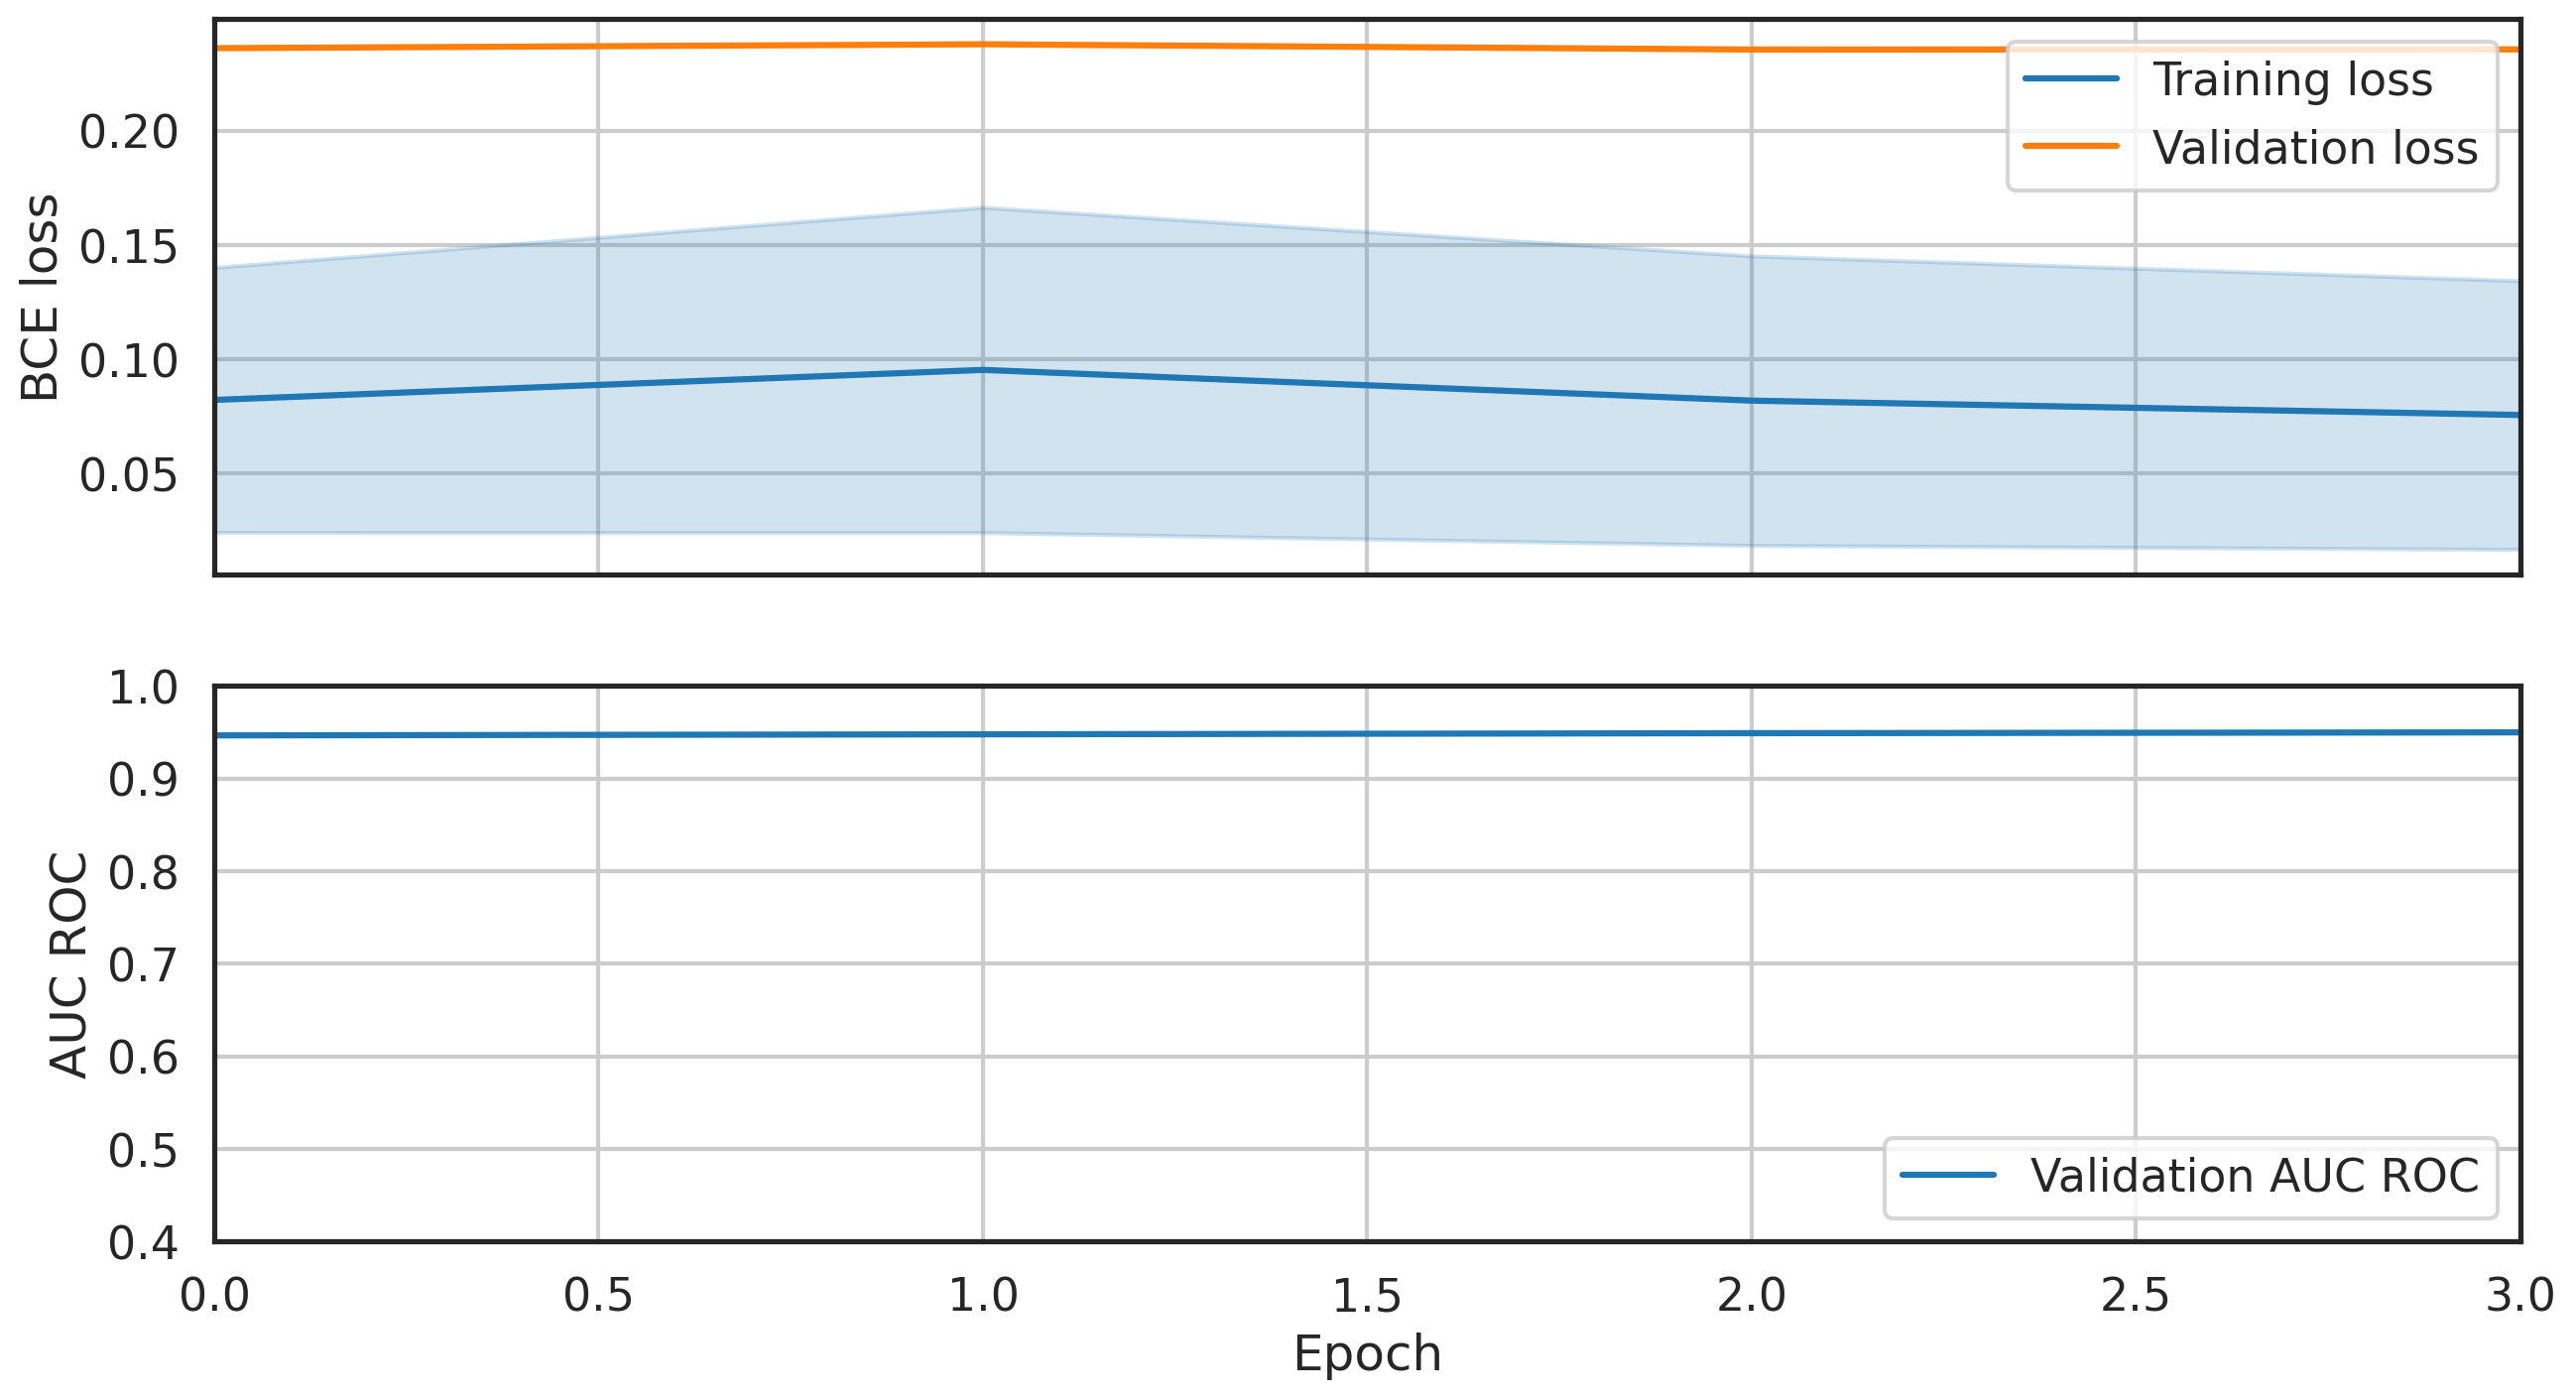

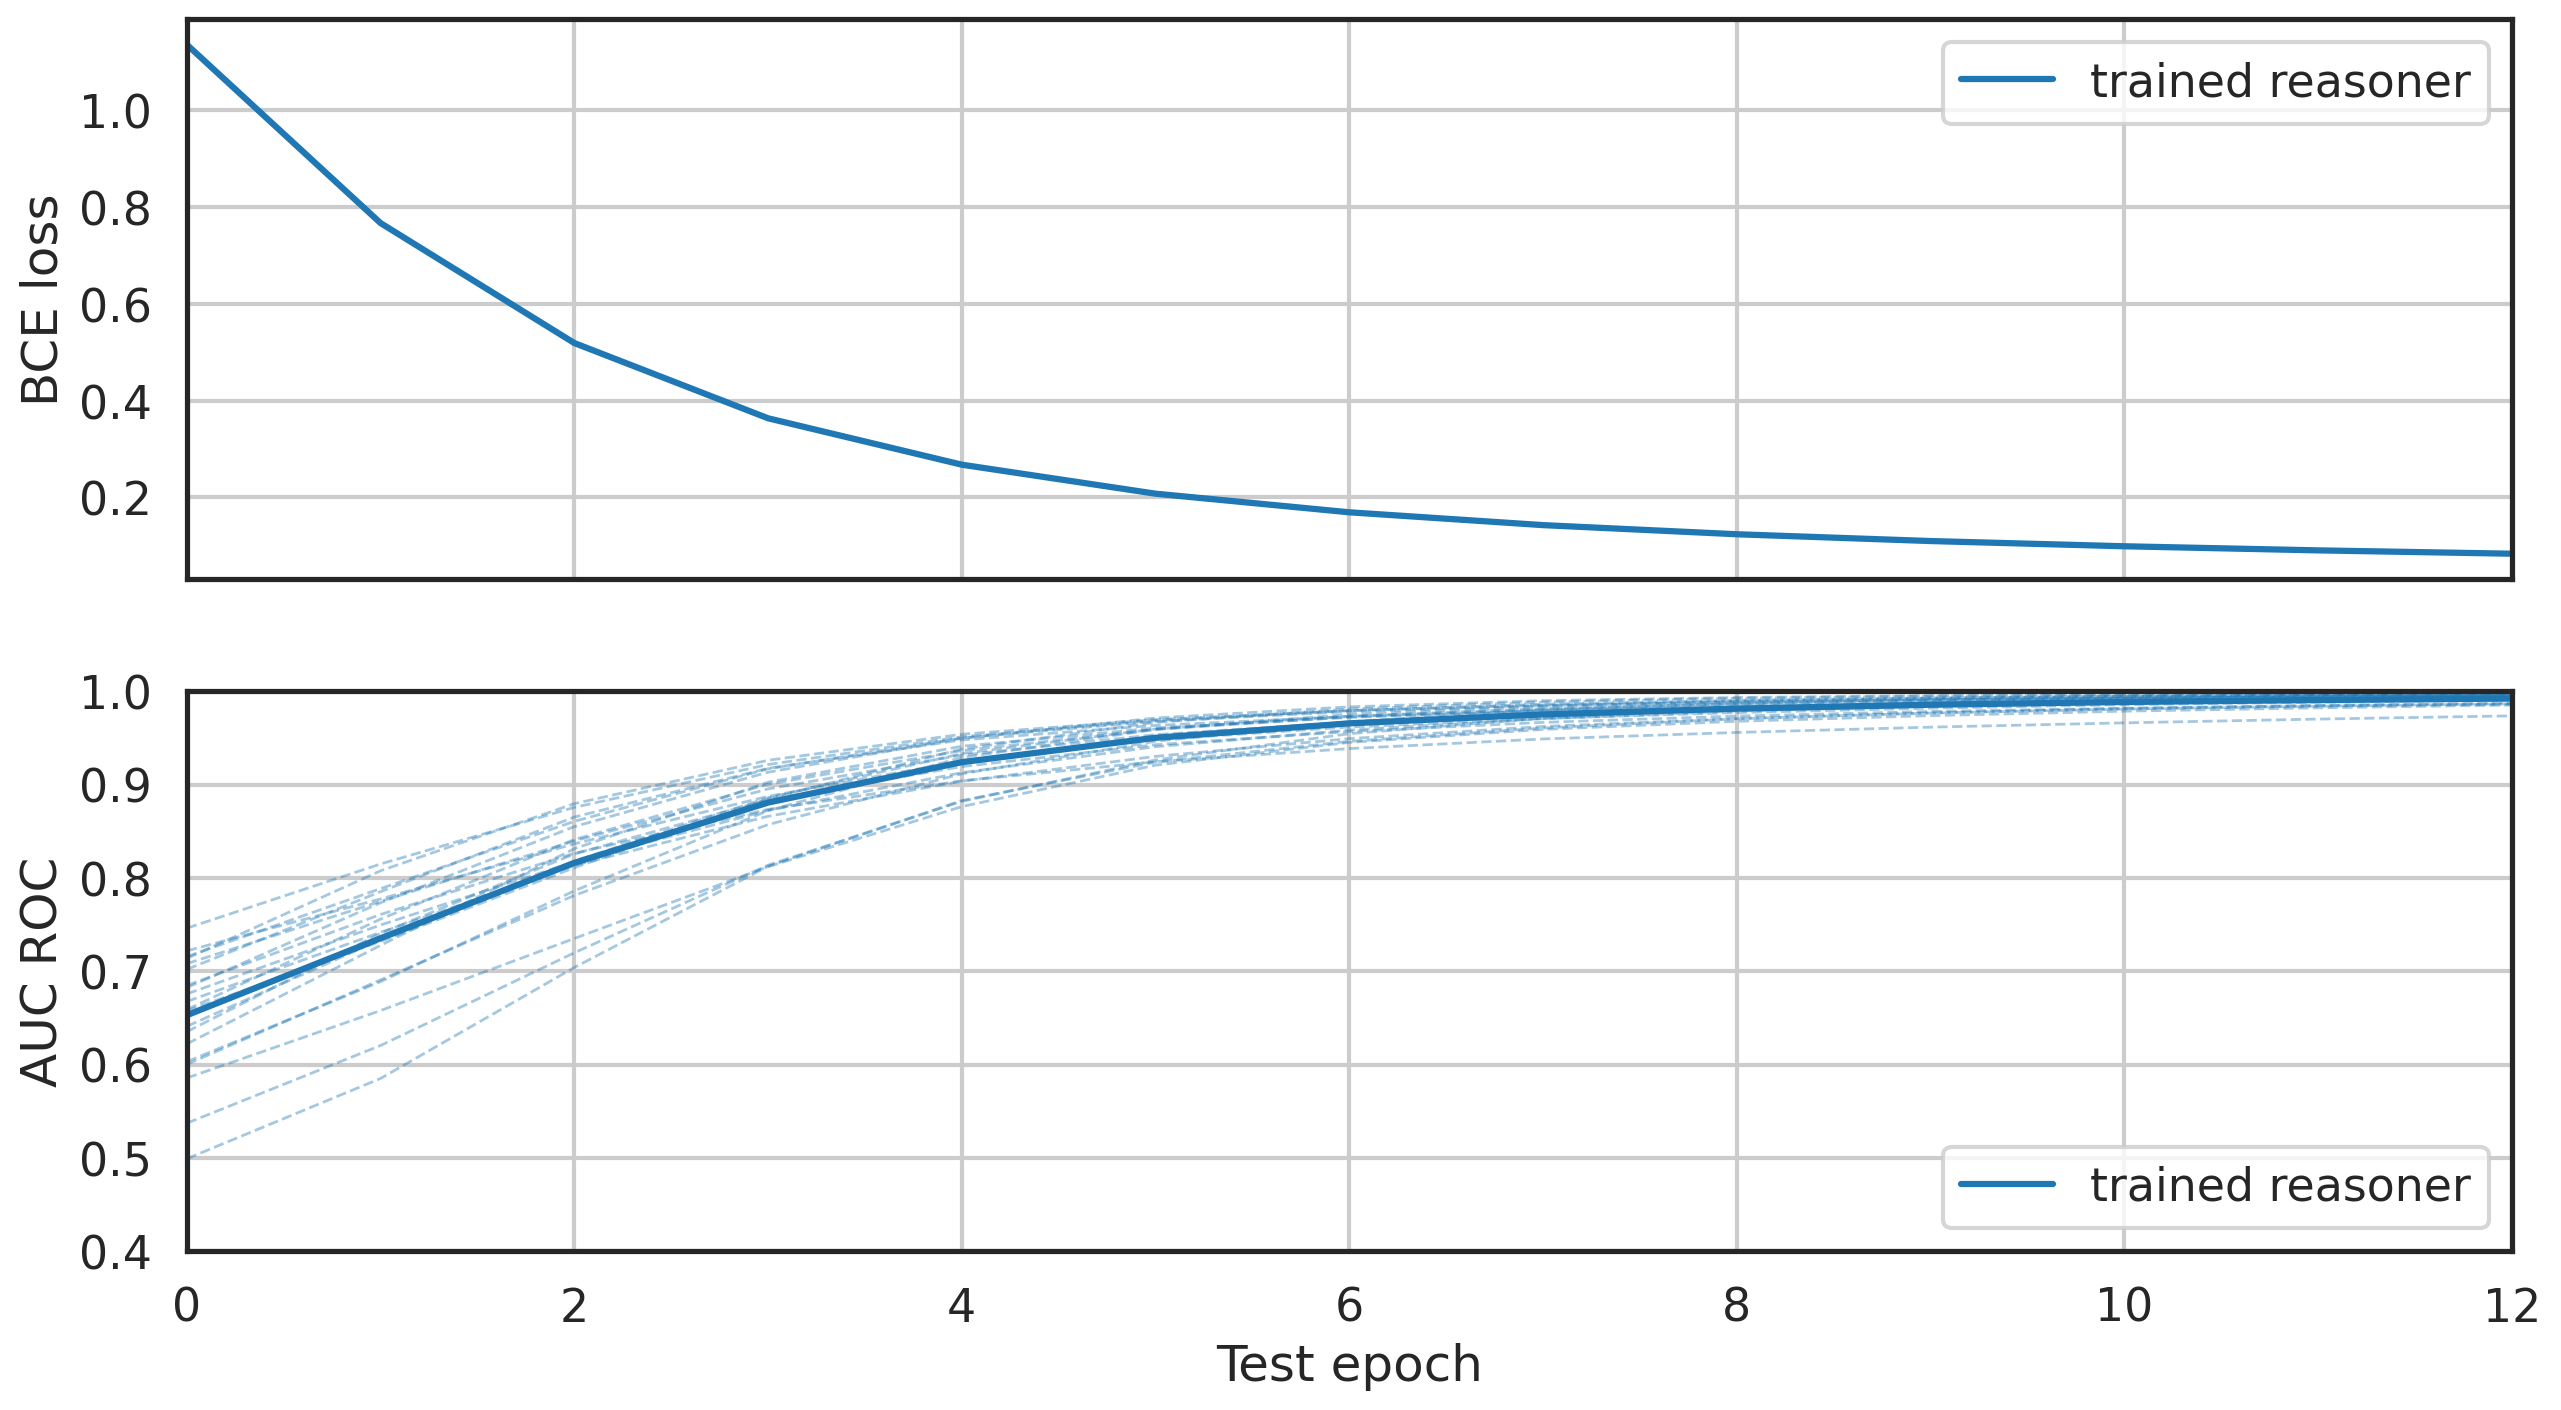

             mean       std     micro
acc      0.969850  0.013737  0.969850
prec     0.965143  0.024368  0.965449
recall   0.892548  0.039453  0.893284
f1       0.927291  0.031748  0.927966
auc_roc  0.992084  0.005938  0.992876
auc_pr   0.979828  0.013139  0.981632


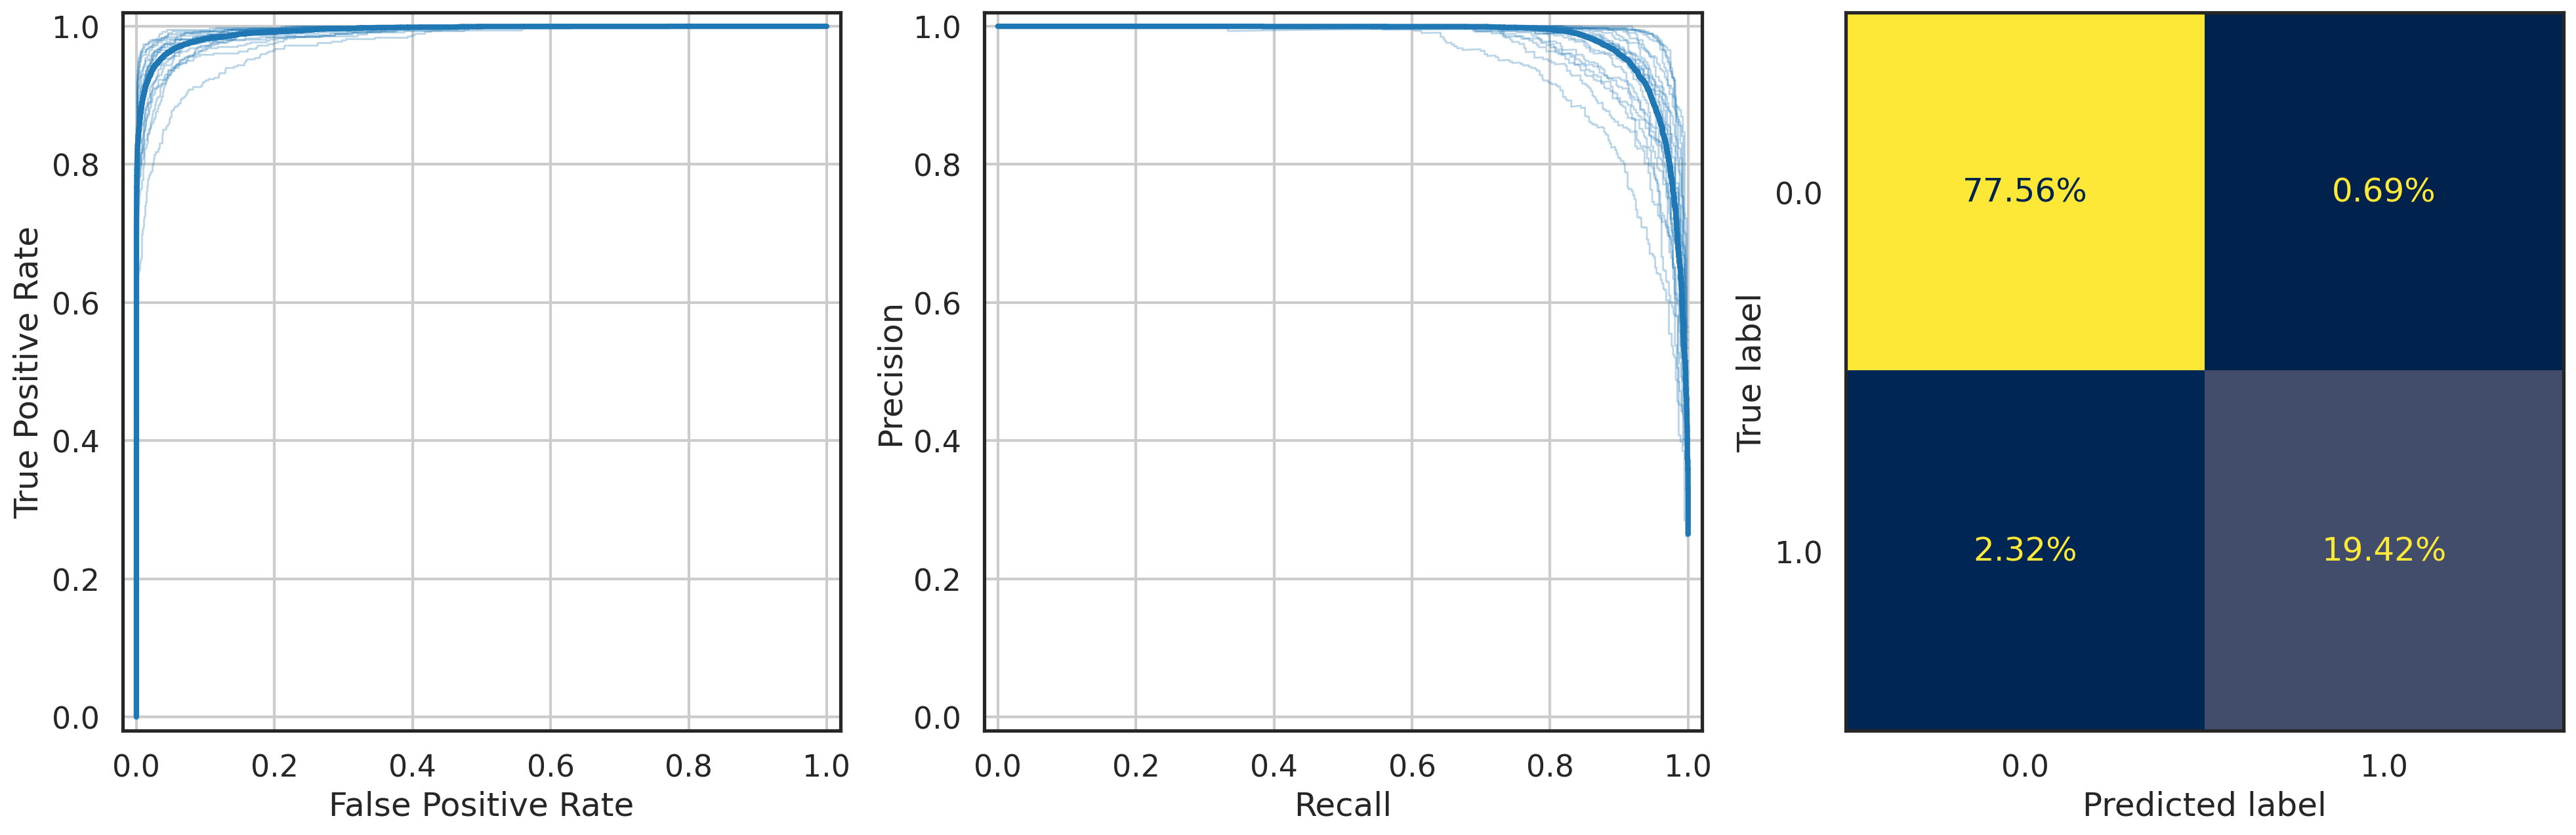

In [8]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

T.save(trained_reasoner.state_dict(), base+'/reasoner.pt')
df_tr = pd.DataFrame(train_logger.history_tr)
df_vl = pd.DataFrame(train_logger.history_vl)
df_tr.to_csv(base+'/train.csv', index=False)
df_vl.to_csv(base+'/valid.csv', index=False)
plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te_good=Y_te_good))#, Y_te_rand=Y_te_rand))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto, save=base+'/test.png')
print(report(test_onto, y_te, np.array(Y_te_good), idx_te, save=base+'/%-trained'))
#print(report(test_onto, y_te, np.array(Y_te_rand), idx_te, save=base+'/%-random'))

In [9]:
T.set_printoptions(precision=4)

In [35]:
encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

print(input)
print(trained_reasoner.and_nn(im_mod( input, input)))
F.mse_loss(input, trained_reasoner.and_nn(im_mod(input, input)))

tensor([ 0.2936,  0.2049,  0.1997,  0.0354, -0.0325, -0.0579,  0.2857, -0.0338,
        -0.0755, -0.2206], grad_fn=<SelectBackward0>)
tensor([ 0.2081,  0.1872,  0.1705, -0.1068,  0.0998, -0.0461,  0.0489, -0.0237,
        -0.0481, -0.1487], grad_fn=<AddBackward0>)


tensor(0.0108, grad_fn=<MseLossBackward0>)

In [36]:
encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

print(trained_reasoner.bot_concept[0])
print(trained_reasoner.and_nn(im_mod(trained_reasoner.bot_concept[0], input)))
print(F.mse_loss(trained_reasoner.and_nn(im_mod(trained_reasoner.bot_concept[0], input)), trained_reasoner.bot_concept[0]))

tensor([ 0.1734,  0.1167,  0.1713, -0.1981,  0.2600, -0.0653, -0.0073,  0.0359,
        -0.1164, -0.0829], grad_fn=<SelectBackward0>)
tensor([ 0.1683,  0.1224,  0.1573, -0.2113,  0.1988, -0.0615, -0.0328,  0.0057,
        -0.0701, -0.0693], grad_fn=<AddBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)


In [37]:
encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

print(input)
print(trained_reasoner.and_nn(im_mod(trained_reasoner.top_concept[0], input)))
print(F.mse_loss(trained_reasoner.and_nn(im_mod(trained_reasoner.top_concept[0], input)), input))


tensor([-0.0352,  0.1218, -0.1782,  0.0053, -0.0215, -0.1212,  0.1840, -0.1889,
         0.0996,  0.0266], grad_fn=<SelectBackward0>)
tensor([-0.0652,  0.0221, -0.1377,  0.0483, -0.0078, -0.0857,  0.1074, -0.1350,
         0.0239,  0.0535], grad_fn=<AddBackward0>)
tensor(0.0031, grad_fn=<MseLossBackward0>)


In [38]:
encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

print(trained_reasoner.bot_concept[0])
output = trained_reasoner.and_nn(im_mod(trained_reasoner.not_nn(input), input))
print(output)
print(F.mse_loss(output, input))


tensor([ 0.1734,  0.1167,  0.1713, -0.1981,  0.2600, -0.0653, -0.0073,  0.0359,
        -0.1164, -0.0829], grad_fn=<SelectBackward0>)
tensor([ 0.0764,  0.0279,  0.0517, -0.1041,  0.0741, -0.1008, -0.0719, -0.0216,
        -0.0190, -0.0301], grad_fn=<AddBackward0>)
tensor(0.0131, grad_fn=<MseLossBackward0>)


In [40]:
print(trained_reasoner.bot_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.top_concept[0])
print(output)
print(F.mse_loss(trained_reasoner.bot_concept[0], output))

tensor([ 0.1734,  0.1167,  0.1713, -0.1981,  0.2600, -0.0653, -0.0073,  0.0359,
        -0.1164, -0.0829], grad_fn=<SelectBackward0>)
tensor([ 0.1975,  0.2014,  0.2287, -0.3243,  0.3270, -0.1101, -0.0181,  0.0375,
        -0.1293, -0.1478], grad_fn=<SqueezeBackward3>)
tensor(0.0038, grad_fn=<MseLossBackward0>)


In [41]:
print(trained_reasoner.top_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.bot_concept[0])
print(output)
print(F.mse_loss(trained_reasoner.top_concept[0], output))

tensor([-0.1333, -0.3136, -0.0888,  0.4924,  0.0674,  0.2580,  0.5921,  0.2636,
        -0.2617,  0.3147], grad_fn=<SelectBackward0>)
tensor([-0.0610, -0.2514, -0.0399,  0.4279,  0.0508,  0.2232,  0.5032,  0.2464,
        -0.2299,  0.2737], grad_fn=<SqueezeBackward3>)
tensor(0.0028, grad_fn=<MseLossBackward0>)


In [42]:
encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
input1 = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
input2 = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
input3 = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

print(trained_reasoner.and_nn(im_mod(input1, trained_reasoner.and_nn(im_mod(input2, input3)))))
print(trained_reasoner.and_nn(im_mod(trained_reasoner.and_nn(im_mod(input1, input2)), input3)))


F.mse_loss(trained_reasoner.and_nn(im_mod(input1, trained_reasoner.and_nn(im_mod(input2, input3)))), trained_reasoner.and_nn(im_mod(trained_reasoner.and_nn(im_mod(input1, input2)), input3)))

tensor([ 0.0543, -0.0047,  0.0609, -0.1272,  0.1115, -0.0563, -0.0347, -0.0337,
        -0.0268, -0.0463], grad_fn=<AddBackward0>)
tensor([ 0.0888, -0.0021,  0.0945, -0.0846,  0.0836, -0.0676, -0.0334, -0.0199,
         0.0235, -0.0581], grad_fn=<AddBackward0>)


tensor(0.0008, grad_fn=<MseLossBackward0>)

In [43]:
print(trained_reasoner.and_nn(im_mod(input1, input3)))
print(trained_reasoner.and_nn(im_mod(input3, input1)))

F.mse_loss(trained_reasoner.and_nn(im_mod(input1, input3)), trained_reasoner.and_nn(im_mod(input3, input1)))

tensor([ 0.0543, -0.0505,  0.0730, -0.0478,  0.0493, -0.0590, -0.0135, -0.0412,
         0.0296, -0.0622], grad_fn=<AddBackward0>)
tensor([ 0.0554, -0.0601,  0.0554, -0.0440,  0.0498, -0.0487, -0.0138, -0.0659,
         0.0362, -0.0623], grad_fn=<AddBackward0>)


tensor(0.0001, grad_fn=<MseLossBackward0>)

In [44]:
print(input1)
print(trained_reasoner.and_nn(im_mod(input1, trained_reasoner.top_concept[0])))

F.mse_loss(input1, trained_reasoner.and_nn(im_mod(input1, trained_reasoner.top_concept[0])))

tensor([-0.2013, -0.2276, -0.1777, -0.0322,  0.0466,  0.0518,  0.1476, -0.1237,
        -0.0883,  0.0223], grad_fn=<SelectBackward0>)
tensor([-0.2223, -0.2275, -0.2015,  0.0487, -0.0325,  0.0306,  0.1380, -0.1070,
        -0.0724,  0.0949], grad_fn=<AddBackward0>)


tensor(0.0020, grad_fn=<MseLossBackward0>)

In [45]:
import numpy as np
import pandas as pd

# Upewnij się, że Y_te i y_te są numpy array
Y_te_2 = np.array(Y_te_good)
y_te_2 = np.array(y_te)
X_te_2 = np.array(X_te)

# Oblicz błędne predykcje
błędne_predykcje = abs(Y_te_2 - y_te_2) > 0.5

# Wyodrębnij rekordy, na których model popełnił błąd
rekordy_z_błędem = X_te_2[błędne_predykcje, :]

# Połącz rekordy z ich prawdziwymi etykietami i predykcjami
wyniki = pd.DataFrame({
    'Rec': np.arange(len(X_te_2))[błędne_predykcje],
    'Tr': y_te_2[błędne_predykcje],
    'Pred': Y_te_2[błędne_predykcje],
})

content_df = pd.DataFrame(rekordy_z_błędem, columns=[f'F_{i}' for i in range(X_te_2.shape[1])])
wyniki = pd.concat([wyniki.reset_index(drop=True), content_df.reset_index(drop=True)], axis=1)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(wyniki)

/tmp/ipykernel_12333/4028119440.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_te_2 = np.array(X_te)


        Rec   Tr      Pred F_0                             F_1           F_2
0        35  1.0  0.067909   2                              36            77
1       135  1.0  0.442694   2                             104            61
2       184  1.0  0.175156   2                               2           109
3       209  1.0  0.490076   2                              15       (3, 91)
4       361  1.0  0.078885   2                              57            71
5       548  1.0  0.125735   0                              58            86
6       575  0.0  0.719125   2                              76  (4, 77, 113)
7       620  1.0  0.011479   0                      (6, 0, 83)            -2
8       621  1.0  0.043361   2                              36           113
9       719  1.0  0.208869   2                              74            11
10      722  1.0  0.300576   0                              39            54
11      853  1.0  0.331265   0                              11            50